In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from collections import Counter
from models import*
from load_data import loaddata,loaddata_with_label_map
from train_utils import *

In [35]:
# class LSTMNet(nn.Module):
#     def __init__(self, input_size, num_classes, dropout_prob=0.5):
#         super(LSTMNet, self).__init__()
        
#         self.lstm1 = nn.LSTM(input_size, 64, batch_first=True)
#         self.lstm2 = nn.LSTM(64, 128, batch_first=True)
#         self.lstm3 = nn.LSTM(128, 64, batch_first=True)
        
#         self.dropout = nn.Dropout(dropout_prob)
        
#         self.fc1 = nn.Linear(64, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, num_classes)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x, _ = self.lstm1(x)
        
#         x, _ = self.lstm2(x)
        
#         x, _ = self.lstm3(x)
#         x = self.dropout(x)
        
#         x = x[:, -1, :]
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x
    
#     def freeze(self, layer_name):
#         # 冻结指定层
#         for param in getattr(self, layer_name).parameters():
#             param.requires_grad = False

#     def unfreeze(self, layer_name):
#         # 解冻指定层
#         for param in getattr(self, layer_name).parameters():
#             param.requires_grad = True

get data from folder

In [5]:
# DATA_PATH = '../WLASL_agument (final)'
DATA_PATH = '/home/lizi/Desktop/WLASL_agument(combine)'


X,Y ,label_map= loaddata(DATA_PATH)
print(label_map)     

(3940, 30, 1662)
(3940,)
{'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}


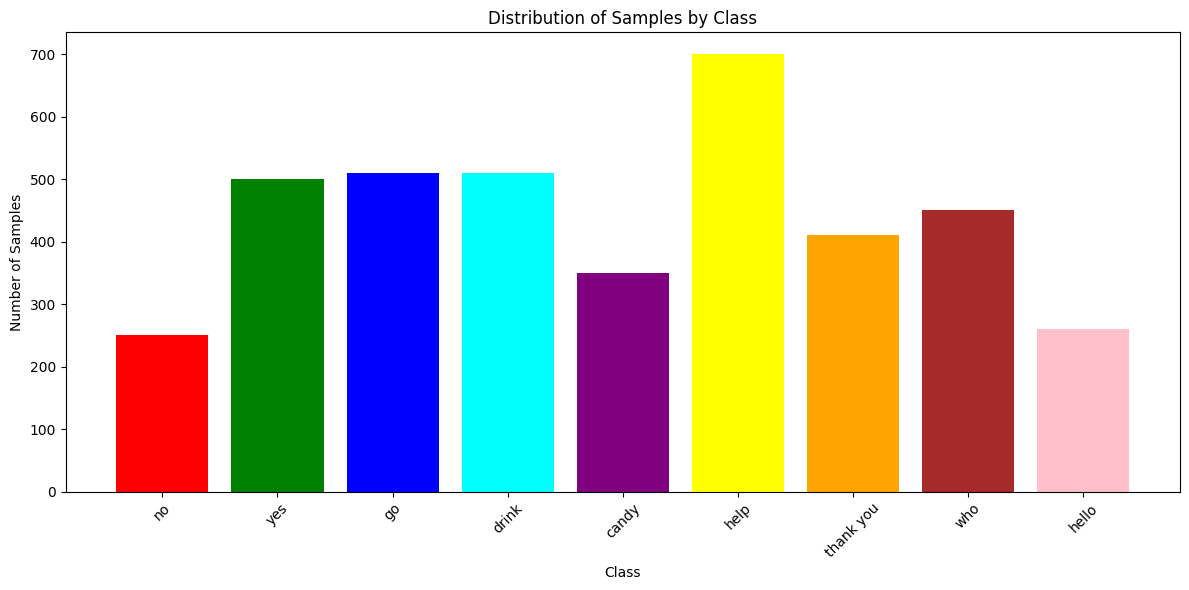

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(Y, label_map):
    # 统计每个类别的样本数量
    unique, counts = np.unique(Y, return_counts=True)
    
    # 准备数据
    # labels = [label_map[key] for key in unique]
    # 从整数标签转换回原始标签名称
    
    labels = [key for key, value in label_map.items() if value in unique]

    values = counts

    # 绘制柱形图
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=['red', 'green', 'blue', 'cyan', 'purple', 'yellow', 'orange', 'brown', 'pink'])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Samples by Class')
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

# 调用函数
label_map = {'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}
plot_class_distribution(Y, label_map)


set the loss function as while as deal with the class imbalance

In [7]:
class_counts = Counter(Y)
print(class_counts)
# 使用类样本数量计算权重
# weights = [1.0 / class_counts[i] for i in range(len(label_map))]
weights = [1.0 / class_counts.get(label_map[label], 1) for label in sorted(label_map, key=label_map.get)]


# 归一化权重，使其总和为1
weights = torch.tensor(weights, dtype=torch.float)
weights = weights / weights.sum()
print(weights)
# move 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weights = weights.to(device)

# 使用权重初始化损失函数
criterion = nn.CrossEntropyLoss(weight=weights)

Counter({5: 700, 2: 510, 3: 510, 1: 500, 7: 450, 6: 410, 4: 350, 8: 260, 0: 250})
tensor([0.1761, 0.0880, 0.0863, 0.0863, 0.1258, 0.0629, 0.1074, 0.0978, 0.1693])


split and load data

In [8]:
#train_test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#set batch size while create dataloader
#train dataloader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#val dataloader
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

<h3>LSTM model

model instantiation & select device 

In [40]:
input_size = 1662
num_classes = len(label_map)
model_lstm = LSTMNet(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train the model

In [41]:
#set learning rate
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.0001)
num_epochs = 60


train_lstm = TrainModel(model_lstm,device,criterion,optimizer)
trained_model_lstm, train_losses, train_accs, val_losses, val_accs = train_lstm.fit(num_epochs,train_loader,val_loader)

Start training!
Epoch: 10/60:Train loss: 1.234,Train acc: 0.526,Val loss: 1.221,Val acc.: 0.529
Epoch: 20/60:Train loss: 0.697,Train acc: 0.754,Val loss: 0.658,Val acc.: 0.783
Epoch: 30/60:Train loss: 0.628,Train acc: 0.793,Val loss: 0.420,Val acc.: 0.872
Epoch: 40/60:Train loss: 0.445,Train acc: 0.841,Val loss: 0.343,Val acc.: 0.869
Epoch: 50/60:Train loss: 0.243,Train acc: 0.939,Val loss: 0.201,Val acc.: 0.940
Epoch: 60/60:Train loss: 0.297,Train acc: 0.910,Val loss: 0.370,Val acc.: 0.882


In [35]:
print(len(train_losses))
print(len(val_losses))

70
70


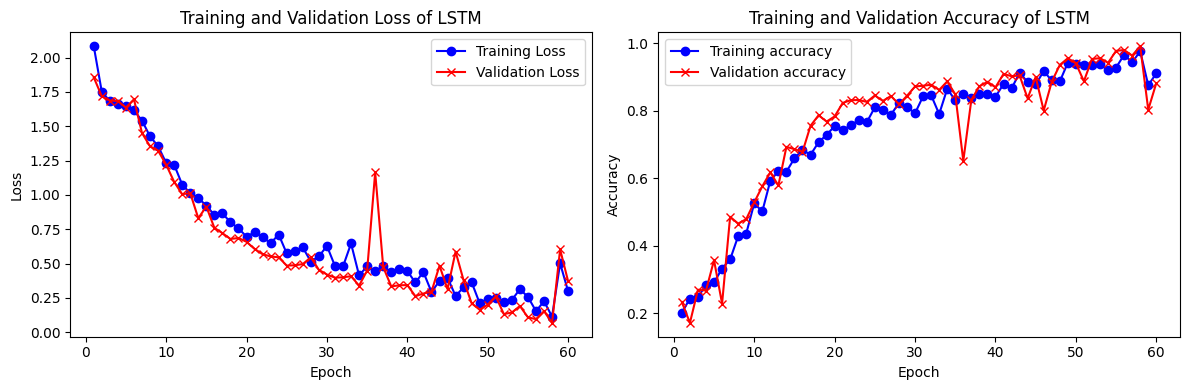

In [42]:
show_result(train_losses,train_accs,val_losses,val_accs)

In [44]:
torch.save({'model_state_dict': trained_model_lstm.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'val_losses': val_losses,
            'val_accs': val_accs,
            }, "./lstm_model.ckpt")

In [12]:
lstm_wlasl_model =LSTMNet(input_size, num_classes)# fill-in the arguments if needed
checkpoint = torch.load("lstm_model.ckpt")
lstm_wlasl_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

lstm_fcn

In [22]:
# DATA_PATH = '../WLASL_agument (final)'
DATA_PATH = '/home/lizi/Desktop/WLASL_agument(combine)'


X,Y ,map= loaddata(DATA_PATH)
print(map)     

(3940, 30, 1662)
(3940,)
{'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}


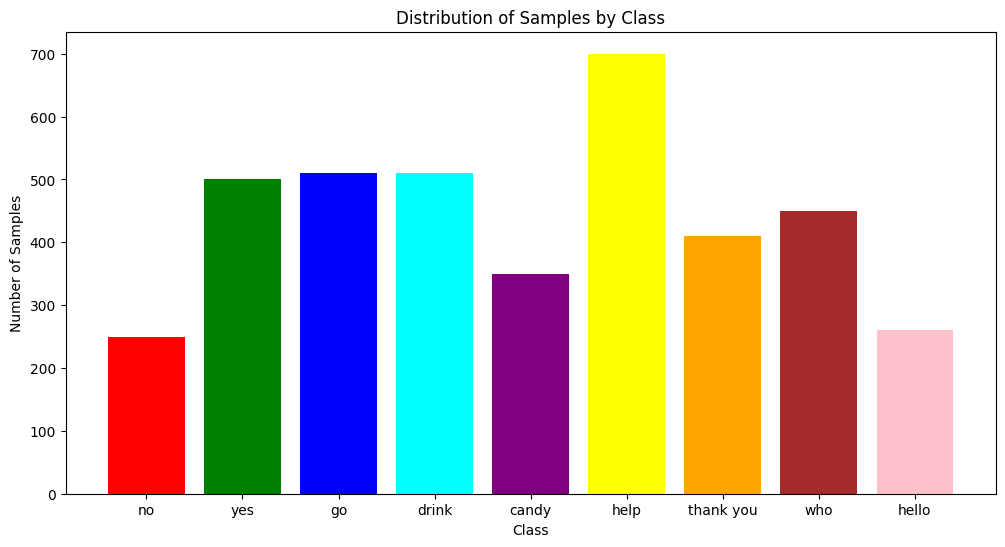

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_distribution(Y, label_map):
    # 统计每个类别的样本数量
    unique, counts = np.unique(Y, return_counts=True)
    
    # 准备数据
    # labels = [label_map[key] for key in unique]
    # 从整数标签转换回原始标签名称
    labels = [key for key, value in label_map.items() if value in unique]

    values = counts

    # 绘制柱形图
    plt.figure(figsize=(12, 6))
    plt.bar(labels, values, color=['red', 'green', 'blue', 'cyan', 'purple', 'yellow', 'orange', 'brown', 'pink'])
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Samples by Class')
    plt.xticks
    plt.show()

# 调用函数
label_map = {'no': 0, 'yes': 1, 'go': 2, 'drink': 3, 'candy': 4, 'help': 5, 'thank you': 6, 'who': 7, 'hello': 8}
plot_class_distribution(Y, label_map)

In [27]:
#train_test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

#set batch size while create dataloader
#train dataloader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(Y_train, dtype=torch.long))
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
#val dataloader
val_data = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(Y_test, dtype=torch.long))
val_loader = DataLoader(val_data, batch_size=10, shuffle=True)

create the instance    modle_lf

In [9]:
input_size = 1662
num_classes = len(label_map)
model_lf = LSTM_FCN(input_size, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train the lstm_FCN

In [28]:
# criterion = nn.CrossEntropyLoss()
#set learning rate
optimizer = torch.optim.Adam(model_lf.parameters(), lr=0.0001)
num_epochs = 60


train_lf = TrainModel(model_lf,device,criterion,optimizer)
trained_model_lf, train_losses_lf, train_accs_lf, val_losses_lf, val_accs_lf = train_lf.fit(num_epochs,train_loader,val_loader)

Start training!
Epoch: 10/60:Train loss: 0.663,Train acc: 0.784,Val loss: 0.732,Val acc.: 0.757
Epoch: 20/60:Train loss: 0.243,Train acc: 0.931,Val loss: 0.245,Val acc.: 0.938
Epoch: 30/60:Train loss: 0.138,Train acc: 0.961,Val loss: 0.275,Val acc.: 0.909
Epoch: 40/60:Train loss: 0.078,Train acc: 0.980,Val loss: 0.051,Val acc.: 0.990
Epoch: 50/60:Train loss: 0.025,Train acc: 0.996,Val loss: 0.029,Val acc.: 0.995
Epoch: 60/60:Train loss: 0.033,Train acc: 0.991,Val loss: 0.088,Val acc.: 0.967


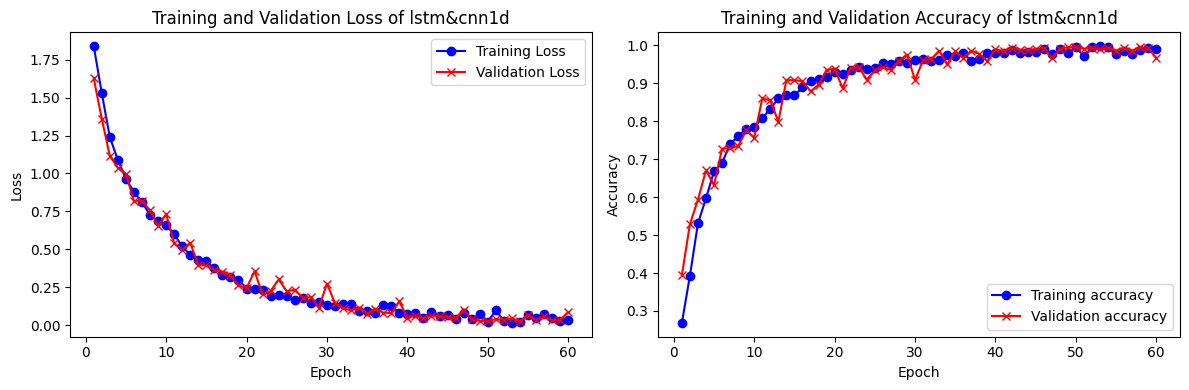

In [36]:
show_result(train_losses_lf, train_accs_lf, val_losses_lf, val_accs_lf,"lstm&cnn1d")

In [51]:
torch.save({'model_state_dict': trained_model_lf.state_dict(),
            'train_losses': train_losses_lf,
            'train_accs': train_accs_lf,
            'val_losses': val_losses_lf,
            'val_accs': val_accs_lf,
            }, "./lstmfcn_model.ckpt")

In [20]:
saved_first_model = LSTM_FCN(input_size, num_classes) # fill-in the arguments if needed
checkpoint = torch.load("lstmfcn_model.ckpt")
saved_first_model.load_state_dict(checkpoint['model_state_dict'])
model_lf = model_lf.to(device)



Confusion matrix wirh lstm_fcn model

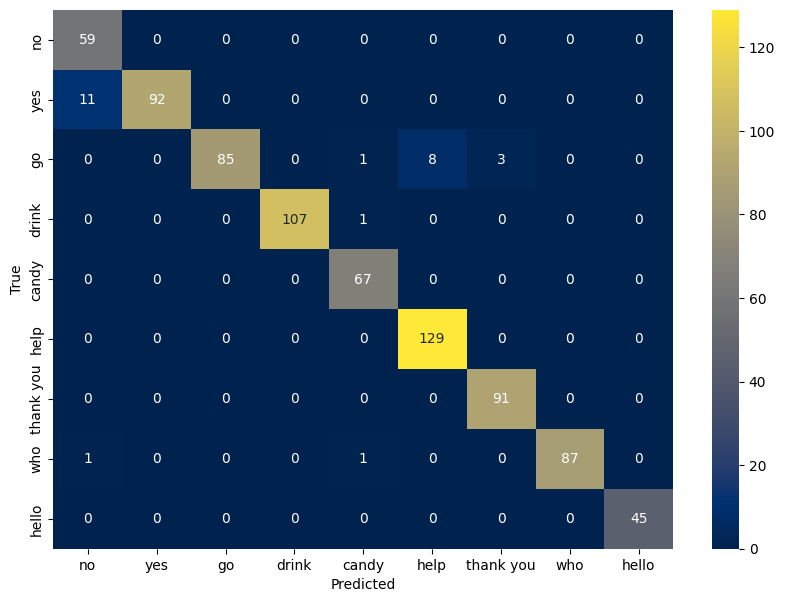

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 设置模型为评估模式
model_lf = model_lf.to(device)
model_lf.eval()

# 收集所有的预测和真实标签
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)  # 如果你使用了GPU
        outputs = model_lf(inputs)
        
        # 获取最大概率的类别作为预测标签
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)



labels = sorted(label_map, key=label_map.get)
# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d")
# sns.heatmap(cm, annot=True, fmt="d", cmap='cividis')
sns.heatmap(cm, annot=True, fmt="d", cmap='cividis', xticklabels=labels, yticklabels=labels)


plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [35]:
from sklearn.metrics import classification_report

# 使用classification_report获得各个类的指标
report = classification_report(all_labels, all_preds, target_names=labels)

print(report)

              precision    recall  f1-score   support

          no       0.83      1.00      0.91        59
         yes       1.00      0.89      0.94       103
          go       1.00      0.88      0.93        97
       drink       1.00      0.99      1.00       108
       candy       0.96      1.00      0.98        67
        help       0.94      1.00      0.97       129
   thank you       0.97      1.00      0.98        91
         who       1.00      0.98      0.99        89
       hello       1.00      1.00      1.00        45

    accuracy                           0.97       788
   macro avg       0.97      0.97      0.97       788
weighted avg       0.97      0.97      0.97       788



Fine tuning with custom data

In [52]:
DATA_PATH = '/home/lizi/Desktop/lizi'

X_my,Y_my = loaddata_with_label_map(DATA_PATH,label_map)

(120, 30, 1662)
(120,)


In [53]:
X_mytrain, X_myval, Y_mytrain, Y_myval = train_test_split(X_my, Y_my, random_state=21,test_size=0.2)
#test dataloader
mytrain = TensorDataset(torch.tensor(X_mytrain, dtype=torch.float), torch.tensor(Y_mytrain, dtype=torch.long))
mytrain_loader = DataLoader(mytrain, batch_size=10, shuffle=True)
#test dataloader
myval = TensorDataset(torch.tensor(X_myval, dtype=torch.float), torch.tensor(Y_myval, dtype=torch.long))
myval_loader = DataLoader(myval, batch_size=10, shuffle=True)

optimizer1 = torch.optim.Adam(model_lstm.parameters(), lr=0.000001)

num_epochs =5

fine_tuning = TrainModel(trained_model_lf,device,criterion,optimizer1)
tuned_lstm, train_losses_tune, train_accs_tune, val_losses_tune, val_accs_tune = fine_tuning.fit(num_epochs,mytrain_loader,myval_loader)

Start training!
